# Custom Model for sentiment analysis

Build a "ANN" model, train it on the amazon reviews dataset and check the accuracy of the model.

We need to convert the reviews to vectors and take them as labels for training our model, \
same with the review_type

In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
df = pd.read_csv('iphone13_clean_csv')
df = df.drop(0)
df = df.reset_index(drop = True)
df.head()

,product,title,rating,review,review_type
0,Apple iPhone 13 (128GB) - Starlight,5.0 out of 5 stars\nAbout the Product,5.0,Its was my long dream to buy an iphone and my ...,good
1,Apple iPhone 13 (128GB) - Starlight,5.0 out of 5 stars\nApple is the king undoubte...,5.0,"Many people says “oh I don’t like iPhones, and...",good
2,Apple iPhone 13 (128GB) - Starlight,5.0 out of 5 stars\nCamera quality,5.0,Image quality is awesome. All the camera lover...,good
3,Apple iPhone 13 (128GB) - Starlight,5.0 out of 5 stars\nABSOLUTELY 10/10,5.0,DISPLAY IS 10/10 PEAK BRIGHTNESS IS CRAZYBATTE...,good
4,Apple iPhone 13 (128GB) - Starlight,5.0 out of 5 stars\nMy first iPhone Experience,5.0,"It is amazing me everyday , so many practical ...",good


### Preprocessing

In [8]:
review_df = df[["review","review_type"]]

In [9]:
from sklearn.preprocessing import OneHotEncoder

type_one_hot = OneHotEncoder(sparse=False).fit_transform(review_df.review_type.to_numpy().reshape(-1, 1))

C:\Users\Shreyas\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [83]:
type_one_hot[0:5]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

the first column is for "BAD reviews", i.e if it's 1 in first column then it is bad review

In [17]:
from sklearn.model_selection import train_test_split

train_reviews, test_reviews, y_train, y_test = train_test_split(review_df.review, 
                                                                type_one_hot, 
                                                                test_size= 0.1, 
                                                                random_state= 4)                                                           

In [18]:
# we need to emmbed the reviews to get vectors, lets use universal sentence encoder from transformers hub
import tensorflow_hub as hub
import tensorflow_text

use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [19]:
from tqdm import tqdm
X_train = []
for r in tqdm(train_reviews):
    emb = use(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_train.append(review_emb)

X_train = np.array(X_train)
X_train[0:2]

100%|██████████| 385/385 [00:18<00:00, 21.11it/s]


array([[ 0.0345172 ,  0.06267893, -0.05674873, ..., -0.0227613 ,
        -0.01623258, -0.00933665],
       [-0.01671571,  0.00587866,  0.00207136, ...,  0.0406719 ,
        -0.05625053, -0.03842795]], dtype=float32)

In [21]:
X_train.shape

(385, 512)

In [22]:
X_test = []
for r in tqdm(test_reviews):
    emb = use(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_test.append(review_emb)

X_test = np.array(X_test)
X_test[0:2]

100%|██████████| 43/43 [00:01<00:00, 22.66it/s]


array([[-0.01468932,  0.0101088 ,  0.00417668, ...,  0.05473149,
         0.04310751, -0.06549034],
       [ 0.01744368, -0.0067172 , -0.01506467, ..., -0.04540636,
        -0.02484543, -0.0222956 ]], dtype=float32)

In [23]:
print("xtrain and xtest shapes: ",X_train.shape, X_test.shape)
print("ytrain and ytest shapes: ",y_train.shape, y_test.shape)

xtrain and xtest shapes:  (385, 512) (43, 512)
ytrain and ytest shapes:  (385, 2) (43, 2)


In [79]:
y_test[0:5]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

the first column is for "BAD reviews", i.e if it's 1 in first column then it is bad review

### Sentiment Analysis

In [72]:
model = keras.Sequential()

model.add(keras.layers.Dense(
    units=64,
    input_shape=(X_train.shape[1], ),
    activation='relu'))
# to avoid overfitting use dropout layers
model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(
    units=32,
    activation='relu'))

model.add(keras.layers.Dense(2, activation='softmax'))

model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(0.0001),
    metrics=['accuracy']
)

In [73]:
history = model.fit(
    X_train, y_train, 
    epochs=40, 
    batch_size=16, 
    validation_split=0.1, 
    #verbose is 1 to show Progress bar with epochs
    verbose=1, 
    #shuffle the training set after every epoch
    shuffle=True
)

Epoch 1/40
22/22 [==============================] - 0s 10ms/step - loss: 0.6901 - accuracy: 0.5549 - val_loss: 0.6942 - val_accuracy: 0.5385
Epoch 2/40
22/22 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.5694 - val_loss: 0.6930 - val_accuracy: 0.5385
Epoch 3/40
22/22 [==============================] - 0s 6ms/step - loss: 0.6839 - accuracy: 0.5838 - val_loss: 0.6911 - val_accuracy: 0.5385
Epoch 4/40
22/22 [==============================] - 0s 6ms/step - loss: 0.6776 - accuracy: 0.6561 - val_loss: 0.6896 - val_accuracy: 0.4872
Epoch 5/40
22/22 [==============================] - 0s 6ms/step - loss: 0.6764 - accuracy: 0.6647 - val_loss: 0.6875 - val_accuracy: 0.5641
Epoch 6/40
22/22 [==============================] - 0s 5ms/step - loss: 0.6704 - accuracy: 0.6329 - val_loss: 0.6857 - val_accuracy: 0.5897
Epoch 7/40
22/22 [==============================] - 0s 6ms/step - loss: 0.6669 - accuracy: 0.6647 - val_loss: 0.6827 - val_accuracy: 0.5897
Epoch 8/40
22/22 [=

__We can see that the val_accuracy is 0.8, since we have a small dataset this is a good result__

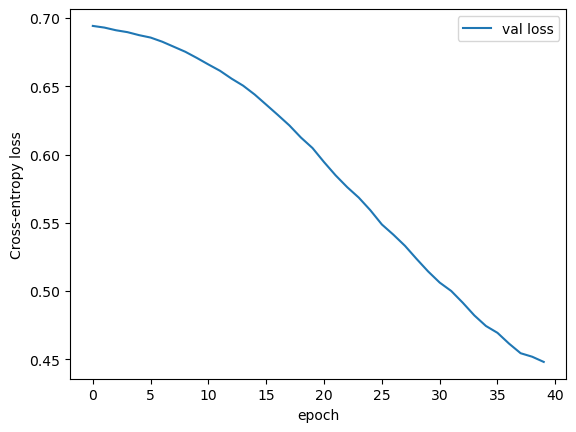

In [74]:
# plot val_loss vs epochs
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend()

__We can see the val loss decrease, this would be more accurate on a larger dataset__

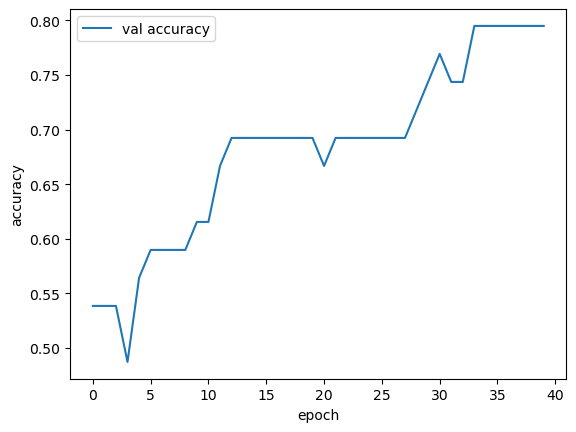

In [75]:
# plot val_accuracy vs epochs
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [76]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 4ms/step - loss: 0.4100 - accuracy: 0.8372


[0.40995997190475464, 0.8372092843055725]

The model has 0.83 accuracy on the test set

### Predictions

In [77]:
y_test_pred = model.predict(X_test)

2/2 [==============================] - 0s 2ms/step


In [84]:
y_test_pred[0:5]

array([[0.22758506, 0.772415  ],
       [0.71329105, 0.28670892],
       [0.6235163 , 0.37648365],
       [0.3503651 , 0.6496349 ],
       [0.40148905, 0.5985109 ]], dtype=float32)

The first column is for "bad reviews", if it is close to 1 then the review is bad else the review is good

In [94]:
print(test_reviews.iloc[10])
print("Bad" if y_test[10][0] == 1 else "Good")

I have ordered one apple i phone 13 256 GB After getting the product it shows some abnormal battery behaviour. After that i tried many times to connect customer service but they are rejecting my call. I spent a huge amount for this product but now i can not replace this item even when the product is not good and its battery life is really bad
Bad


In [98]:
"Bad" if np.argmax(y_test_pred[10]) == 0 else "Good"

'Bad'

__we can see that both test and predicted values are showing "Bad"__

In [100]:
print(test_reviews.iloc[0])
print("Bad" if y_test[0][0] == 1 else "Good")

Good product by
Good


In [101]:
"Bad" if np.argmax(y_test_pred[0]) == 0 else "Good"

'Good'

__confusion matrix__

In [117]:
y_test_type = []
for i in y_test:
    rev = "Bad" if i[0] == 1 else "Good"
    y_test_type.append(rev)

In [126]:
y_pred_type = []
for v in y_test_pred:
    rev1 = "Bad" if np.argmax(v) == 0 else "Good"
    y_pred_type.append(rev1)

In [130]:
from sklearn.metrics import confusion_matrix
class_mapping = {"Bad": 0, "Good": 1}

# Convert class labels to binary values
y_test_bin = [class_mapping[label] for label in y_test_type]
y_pred_bin = [class_mapping[label] for label in y_pred_type]
# Calculate the confusion matrix
cm = confusion_matrix(y_test_bin, y_pred_bin)
cm

array([[23,  1],
       [ 6, 13]], dtype=int64)

Text(95.72222222222221, 0.5, 'y_test_type')

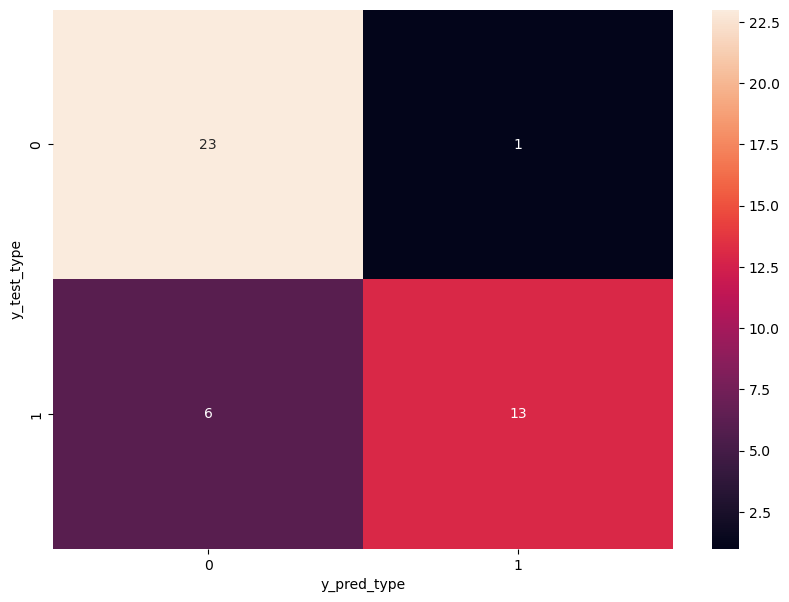

In [131]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot =True, fmt='d')
plt.xlabel('y_pred_type')
plt.ylabel('y_test_type')

out of 24 bad reviews, 23 where predicted correctly \
out of 19 good reviews, 13 where predicted correctly